In [4]:
import numpy as np
import math
from matplotlib import mlab
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import scipy as sp
import random
import networkx as nx
import dwave_networkx as dnx

from dwave.system.samplers import DWaveSampler
from dwave.system.composites import EmbeddingComposite
from collections import Counter


In [186]:
def show(voc): #По словарю строится граф
    n = len(voc)
    G = nx.DiGraph()
    for i in range(n - 1):
        G.add_edge(voc[i], voc[i+1])
    G.add_edge(voc[n - 1], voc[0])


    pos = nx.spring_layout(G)
    nx.draw_networkx_nodes(G, pos, node_size=700 )
    nx.draw_networkx_labels(G,pos,font_size=20,font_family='sans-serif')
    nx.draw_networkx_edges(G, pos, arrowstyle='->', arrowsize=30)  

    plt.axis('off')
    plt.savefig("weighted_graph.png") 
    plt.show()
    return(G) 

def graph(n, k): #Генерация рида и k-меров
    voc = {0:'A', 1:'T', 2:'G', 3:'C'}
    g_read = [0]*n
    
    for i in range(n):
        g_read[i] = voc.get(random.randint(0,3))
    print('read = ', g_read)
    
    t = int(len(g_read) - k + 1)
    
    kmers = [0]*(t)
    
    for i in range(t):
        l = ''
        for j in range(k):
            l = l + g_read[i + j]
            kmers[i] = l
    G = kmers
    print('k-mers = ', G)
    dict = {}
    for i in range(len(G)):
        dict[i] = G[i]
    
    g = show(dict)
    return(dict)

def matrix(voc): #По графу строится матрица смежности
    n = len(voc)
    G = nx.DiGraph()
    for i in range(n - 1):
        G.add_edge(voc[i], voc[i+1])
    G.add_edge(voc[n - 1], voc[0])
    
    adj_matrix = nx.adjacency_matrix(G)
    M = adj_matrix.todense()
    return(M)
    


def adj(M, i1, i2): #Проверка наличия E(i1,i2)
    dict = []

    for j in range(len(M)):
        if M[i1,j] == 1:
            dict.append(j)

    return(i2 in dict)


def generate_qubo(M):    
    varsDict = {}
    n = len(M)
    index = 0
    for i in range(n):
        for j in range(n) :
            varsDict [( i , j ) ] = index
            index += 1
            #print(varsDict)

    Q = {}
    for i in range(n*n):
        for j in range(n*n):
            Q[i, j] = 0
    #p1
    for i in range(n):
        for iprime in range(n) :
            index = varsDict[(i, iprime)]
            Q[index, index] -= 2
            #print(index) 

        for iprime1 in range(n):
            for iprime2 in range(n):
                index1 = varsDict[(i, iprime1)]
                index2 = varsDict[(i, iprime2)]
                Q[index1, index2] += 1
                #print(index1, index2, Q[index1, index2])

    #p2
    for iprime in range(n):
        for i in range(n):
            index = varsDict[(i , iprime)]
            Q[index, index] -= 2
            #print(index, iprime, Q[index, index])

        for i1 in range(n):
            for i2 in range(n):
                index1 = varsDict[(i1, iprime)]
                index2 = varsDict[(i2, iprime)]
                Q[index1, index2] += 1
                #print(index1, index2, Q[index1, index2])


    for i_1 in range(n):
         for i_2 in range(n):
            if (adj(M, i_1, i_2)) != True and (i_1 != i_2):
                for j in range(n - 1):
                    index_1 = varsDict[i_1, j]
                    index_2 = varsDict[i_2, j ]
                    Q[index_1, index_2] += 1
                     
                index_1 = varsDict[i_1, n -1] 
                index_2 = varsDict[i_2 , 0]

                Q[index_1, index_2 ] += 1
 
    #for i in range(n*n):
    #        for j in range(n*n):
    #            if (i > j) and (not (Q[i, j]==0)):
    #                Q[j, i] += Q [i, j]
    #                Q[i, j] = 0
    return Q, varsDict

def way(Sample, k, vD): #Восстановление путей по цепочки спинов
    x = [0]*k
    vd = list()

    for K in vD.keys(): 
        vd.append(K)
    #print(vd, len(vd))
    
    j = 0
    for i in range(k*k):
        if Sample[i] == 1:
            x[j] = i
            j = j + 1

    d = [0]*k
    for i in range(k):
        d[i] = vd[x[i]][1] 
    return(d)

def genome_way(d, dict): #Восстановление генома по номерам вершин
    genome = []
    for k in range(len(d)): 
        genome.append(dict[d[k]])
    return genome

def delete_repeats(d): #Удаление повторяющихся путей 

    def delete(i, d):
        j = 0
        while j < len(d):
            #print(i, j, len(d) - 1)
            if d[i] == d[j] and i != j:
                del d[j]
            j = j + 1
        return d, len(d)

    i = 0

    while i < len(d):
        d = delete(i, d)[0]
        i = i + 1

    return d    



In [200]:
def dwave(Q, len_M, vD):
    sampler = EmbeddingComposite(DWaveSampler())
    response = sampler.sample_qubo(Q, num_reads=5000)
    d = []
    for sample, energy, occurrences in response.data(['sample', 'energy', 'num_occurrences']): 
        if energy == - len_M*2:
            print("Sample:", sample, "Energy: ", energy, "Occurrences: ", occurrences)
            d.append(way(sample, len_M, vD))
            print(d)
    return(d)

read =  ['T', 'C', 'G', 'A', 'G', 'T']
k-mers =  ['TCG', 'CGA', 'GAG', 'AGT']


d:\python\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
d:\python\lib\site-packages\networkx\drawing\nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


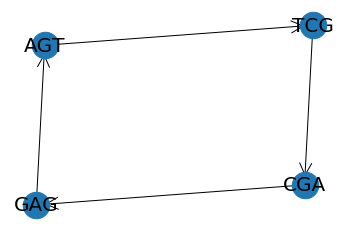

[[0 1 0 0]
 [0 0 1 0]
 [0 0 0 1]
 [1 0 0 0]]
[-2, 1, 1, 1, 1, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0]
[1, -2, 1, 1, 0, 1, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0]
[1, 1, -2, 1, 0, 0, 1, 0, 0, 0, 2, 0, 0, 0, 2, 0]
[1, 1, 1, -2, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1]
[2, 0, 0, 0, -2, 1, 1, 1, 1, 0, 0, 0, 2, 0, 0, 0]
[0, 2, 0, 0, 1, -2, 1, 1, 0, 1, 0, 0, 0, 2, 0, 0]
[0, 0, 2, 0, 1, 1, -2, 1, 0, 0, 1, 0, 0, 0, 2, 0]
[1, 0, 0, 1, 1, 1, 1, -2, 0, 0, 0, 1, 1, 0, 0, 1]
[2, 0, 0, 0, 2, 0, 0, 0, -2, 1, 1, 1, 1, 0, 0, 0]
[0, 2, 0, 0, 0, 2, 0, 0, 1, -2, 1, 1, 0, 1, 0, 0]
[0, 0, 2, 0, 0, 0, 2, 0, 1, 1, -2, 1, 0, 0, 1, 0]
[1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, -2, 0, 0, 0, 1]
[1, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, -2, 1, 1, 1]
[0, 1, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 1, -2, 1, 1]
[0, 0, 1, 0, 0, 0, 2, 0, 0, 0, 2, 0, 1, 1, -2, 1]
[0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, -2]
{(0, 0): 0, (0, 1): 1, (0, 2): 2, (0, 3): 3, (1, 0): 4, (1, 1): 5, (1, 2): 6, (1, 3): 7, (2, 0): 8, (2, 1): 9, (2, 2): 10, (2, 3): 11, (3, 0): 12, (3, 1): 

In [193]:
G = graph(6, 3)
M = matrix(G)
print(M)
len_M = len(M)

qubo = generate_qubo(M)
Q = qubo[0]
vD = qubo[1]

for i in range(len_M*len_M):
    print([Q[i,j] for j in range(len_M*len_M)])

print(vD)
 
    

In [203]:
d = dwave(Q, len_M, vD)

Sample: {0: 1, 1: 0, 2: 0, 3: 0, 4: 0, 5: 1, 6: 0, 7: 0, 8: 0, 9: 0, 10: 1, 11: 0, 12: 0, 13: 0, 14: 0, 15: 1} Energy:  -8.0 Occurrences:  2
[[0, 1, 2, 3]]
Sample: {0: 0, 1: 0, 2: 1, 3: 0, 4: 0, 5: 1, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 1, 12: 1, 13: 0, 14: 0, 15: 0} Energy:  -8.0 Occurrences:  4
[[0, 1, 2, 3], [2, 1, 3, 0]]
Sample: {0: 0, 1: 0, 2: 1, 3: 0, 4: 0, 5: 1, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 1, 12: 1, 13: 0, 14: 0, 15: 0} Energy:  -8.0 Occurrences:  2
[[0, 1, 2, 3], [2, 1, 3, 0], [2, 1, 3, 0]]
Sample: {0: 1, 1: 0, 2: 0, 3: 0, 4: 0, 5: 1, 6: 0, 7: 0, 8: 0, 9: 0, 10: 1, 11: 0, 12: 0, 13: 0, 14: 0, 15: 1} Energy:  -8.0 Occurrences:  1
[[0, 1, 2, 3], [2, 1, 3, 0], [2, 1, 3, 0], [0, 1, 2, 3]]


In [205]:
delete_repeats(d)
d


[[0, 1, 2, 3], [2, 1, 3, 0]]

In [206]:
for i in range(len(d)):
    print('way',i,'=',genome_way(d[i], G))

way 0 = ['TCG', 'CGA', 'GAG', 'AGT']
way 1 = ['GAG', 'CGA', 'AGT', 'TCG']
